In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag

#autocomplete
%config IPCompleter.greedy=True

#set plt graphs to display with default settings
plt.rcdefaults()

#removes wrapping from displayed dataframes
pd.set_option('display.expand_frame_repr', True)

# Increase DF column width?
# pandas.set_option('display.max_colwidth', 1000)

### Setting up the data

In [3]:
#Read the file into a dataframe
df = pd.read_json('the_Donald-2018-04-27-submissionData.json', convert_dates=['created_utc'])

# Create a Pandas series of just the title text
df_titletext = df['title']

# Create a Pandas series of just the selftext of each post excluding all deleted or removed posts
df_selftext = df[(df['selftext'] != "") &  (df['selftext'] != "[deleted]") & (df['selftext'] != "[removed]")] 

# Sets stopwords to basic English dictionary
sw = stopwords.words('english')

# Creates regular expression for tokenization
ret = RegexpTokenizer('[a-zA-Z\']+')

# Instatiates the Lemmatizer for getting base words
lem = WordNetLemmatizer()

# Exploring the data



### Basic Information
Below is some basic information on the data.

In [3]:
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188795 entries, 0 to 188794
Data columns (total 13 columns):
author          188795 non-null object
created_utc     188795 non-null datetime64[ns]
downs           188795 non-null int64
gilded          188795 non-null int64
num_comments    188795 non-null int64
over_18         188795 non-null object
score           188795 non-null int64
selftext        188795 non-null object
subreddit       188795 non-null object
title           188795 non-null object
ups             188795 non-null int64
upvote_ratio    188795 non-null float64
url             188795 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(6)
memory usage: 18.7+ MB


,author,created_utc,downs,gilded,num_comments,over_18,score,selftext,subreddit,title,ups,upvote_ratio,url
0,None,2017-01-14 05:26:08,6,0,0,False,12,,The_Donald,Besides FAKE NEWS we also have FAKE VICTIMIZAT...,18,0.66,https://i.redd.it/9dmsj7525m9y.jpg
1,Husky455,2018-01-02 02:34:04,12,0,1,False,35,,The_Donald,I think we're in the outer bands of this Storm...,47,0.75,https://imgur.com/bZrsBo3
2,mbp4295,2017-12-22 15:19:51,218,0,95,False,5239,,The_Donald,"Seriously Barry, you’re a blooming idiot.",5457,0.96,https://i.redd.it/nmxa2nsxqh501.jpg
3,from_the_dont,2017-05-02 01:12:38,9,0,3,False,27,I was afraid that the Democrats would take ove...,The_Donald,"Reviewing the budget deal, it's clear that we ...",36,0.75,https://www.reddit.com/r/The_Donald/comments/6...
4,kingsolomon1337,2017-12-06 18:36:53,13,0,0,False,42,,The_Donald,LEGENDARY,55,0.77,https://i.redd.it/tc29a35ijc201.jpg


In [13]:
df.describe()

,downs,gilded,num_comments,score,ups,upvote_ratio
count,188795.000000,188795.000000,188795.000000,188795.000000,188795.000000,188795.000000
mean,29.330570,0.000249,8.593580,276.751535,306.082105,0.780232
std,282.907743,0.017973,57.126865,1090.832161,1280.734564,0.134100
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000
25%,4.000000,0.000000,0.000000,9.000000,14.000000,0.670000
50%,8.000000,0.000000,1.000000,21.000000,30.000000,0.750000
75%,13.000000,0.000000,4.000000,60.000000,74.000000,0.920000
max,22148.000000,4.000000,8610.000000,34642.000000,56790.000000,1.000000


In [15]:
df['downs'].max()

22148

### Some Basic Visualizations

Below is a subplot (Figure 1a) containing a few scatter plots showing the numeric data plotted.
- Scatterplot of upvotes against downvotes. 
- Scatterplot of number of comments against downvotes
- Scatterplot of upvote ratio against downvotes

Downvotes was chosen as the constant x value to see what information can be seen from the amount of people who "disagreed" with each submission.  

There are a few interesting observations you can see from the scatterplots. For instance, the largest mass of posts have upvotes outdistance downvotes by a scale of approximately 2:1 - this can be better seen in the expanded scatterplot in figure 1b

### FIGURE 1a

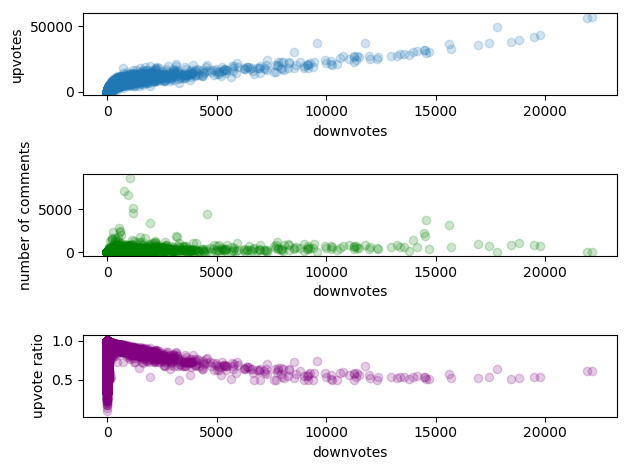

In [53]:
plt.subplot(3, 1, 1)
#plt.suptitle('TITLE')
plt.scatter(x=df.downs, y=df.ups, alpha=0.2)
plt.ylabel('upvotes')
plt.xlabel('downvotes')
plt.subplot(3, 1, 2)
plt.scatter(x=df.downs, y=df.num_comments, c='g', alpha=0.2)
plt.ylabel('number of comments')
plt.xlabel('downvotes')
plt.subplot(3, 1, 3)
plt.scatter(x=df.downs, y=df.upvote_ratio, c='purple', alpha=0.2)
plt.ylabel('upvote ratio')
plt.xlabel('downvotes')
plt.tight_layout()
plt.show()

### FIGURE 1b

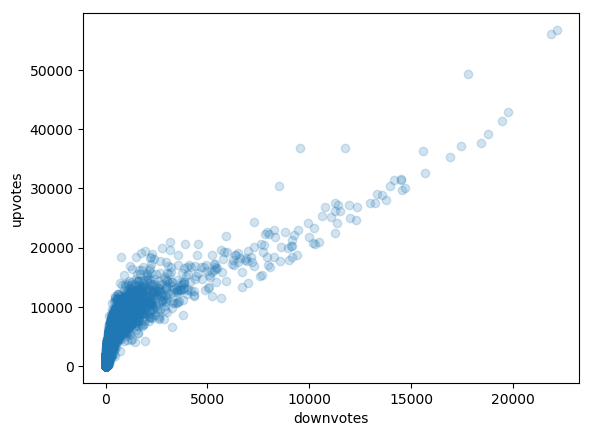

In [54]:
plt.scatter(x=df.downs, y=df.ups, alpha=0.2)
plt.ylabel('upvotes')
plt.xlabel('downvotes')
plt.show()

Lets take a look at the title with the most downvotes

In [28]:
df.loc[df['downs'].idxmax(), 'title']

'Just the 45th President. (doing my part)'

## Wordclouds

So now we're going to take a look at some of the words that are important to the subreddit, and generate a wordcloud from those words. 

However first we're going to have to clean the titles up a bit. To get an accurate depiction of what words the subreddit consider important, we will tokenize each word, convert it to lowercase, then remove all the basic stop words such as:
- I 
- we 
- the 
- and 

This method helps lemmatize words using NLTK's word tagging system:

In [30]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''  

The first tokenization method, not only tokenizes words, but also lemmetizes the word using a secondary function to help cut down on similiar words in the titles. 

In [71]:
def corpus_tokenize(data):
    tokenize_title_text = [ret.tokenize(t) for t in data]
    tagged_flat_text_list = [pos_tag(word) for word in tokenize_title_text]
    flat_text_list = [item for sublist in tagged_flat_text_list for item in sublist]
    tagged_flat_text_list = [(word, get_wordnet_pos(tag)) for word, tag in flat_text_list]
    almost_complete = [lem.lemmatize(t.lower(), tag) for t, tag in tagged_flat_text_list if tag != ''] 
    complete = [t for t in almost_complete if t not in sw and len(t) > 1]
    
    return complete

Creating the bag-of-words to create wordclouds out of:

In [32]:
bag_of_words_corpus = corpus_tokenize(df_titletext)
bow_simple = Counter(bag_of_words_corpus)

Here's what the sum total of every single one of our submission titles looks like now. 

In [9]:
bag_of_words_corpus[:20]

['fake',
 'news',
 'also',
 'fake',
 'victimization',
 'think',
 "we're",
 'outer',
 'band',
 'storm',
 'get',
 'real',
 'gusty',
 'seriously',
 'barry',
 'blooming',
 'idiot',
 'review',
 'budget',
 'deal']

### So here's the basic wordcloud


### FIGURE 2a

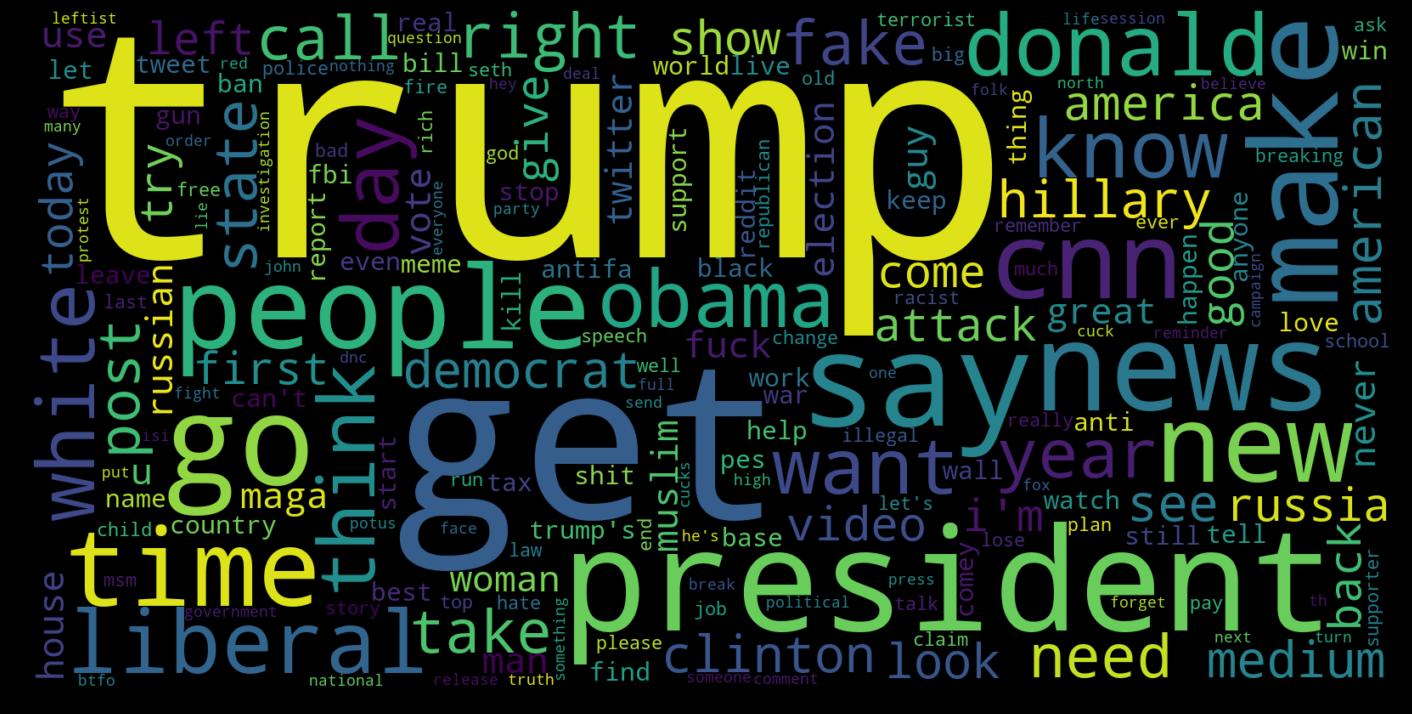

In [33]:
wordcloud = WordCloud(width=1600, height=800)
wordcloud.generate_from_frequencies(frequencies=bow_simple)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=1)
plt.show()

Well, it is a subreddit about President Donald Trump after all. Shouldn't be too supring that his name and title take up the vast majority of the space, right? 


Let's see what happens when we add those to our stopwords dictionary. Let's also add some of the basic words we can see used a lot such as 
- like
- get
- make
- would
- new
- go
- say
- get

### FIGURE 2b

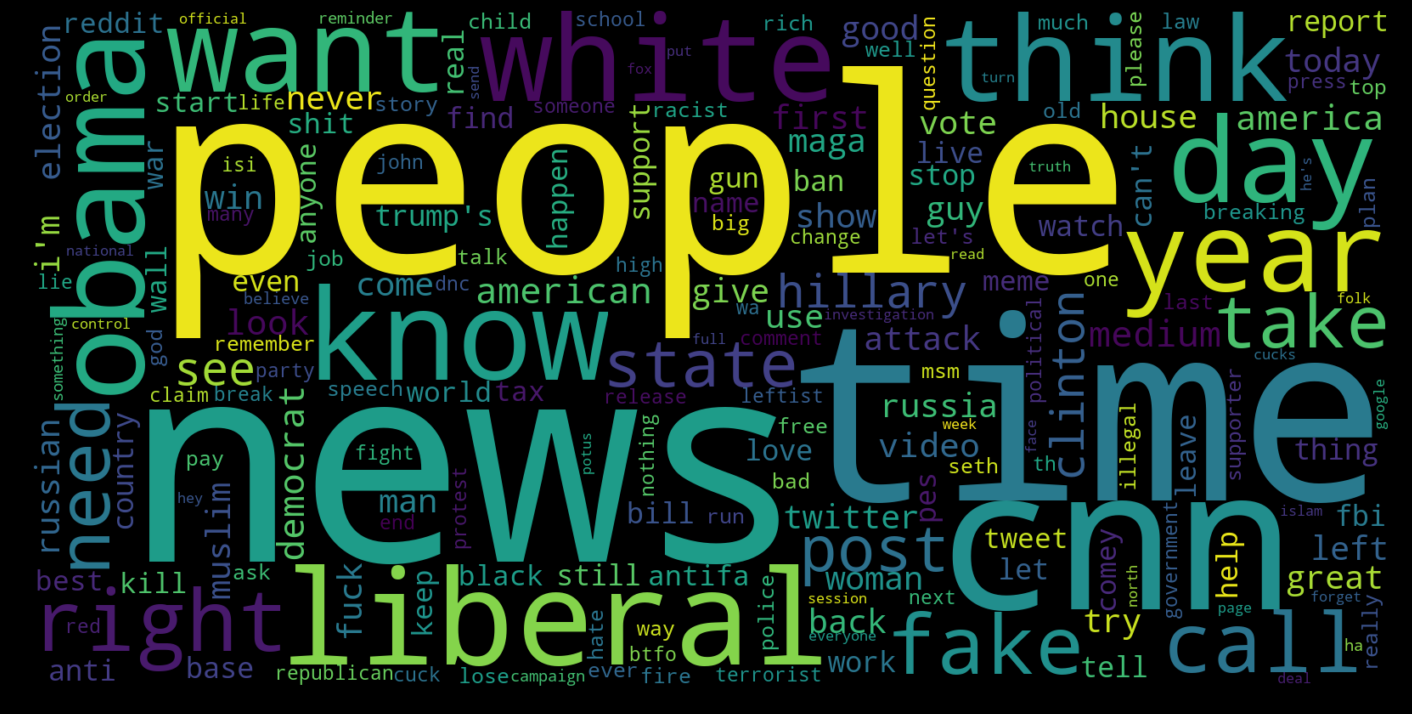

In [72]:
sw.extend(('donald', 'trump', 'president', 'like', 'get', 'make', 'would', 'new', 'go', 'say', 'get'))

bag_of_words_corpus = corpus_tokenize(df_titletext)
bow_simple = Counter(bag_of_words_corpus)

wordcloud = WordCloud(width=1600, height=800)
wordcloud.generate_from_frequencies(frequencies=bow_simple)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=1)
plt.show()

Some of the words in the refined wordcloud seem pretty usual: want, think, time, need, right. Others aren't too suprising given the context 

# Topic Modeling using LDA and Gensim

Below we will use the LDA model in Gensim to model some basic topic lists from the submission titles.

In [39]:
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel

This tokenizer function will be a little different than the one we used for constructing wordclouds. This is beacuse we will be creating topics based on the number of documents (titles in this case) as well as the number of times a word appears. 

In [40]:
def tokenizer_for_gensim(sentence):
    tokens = ret.tokenize(sentence)
    sentence = [lem.lemmatize(t.lower()) for t in tokens if t.lower() not in sw and len(t) >1]
    return sentence

In [41]:
tokenized_titles_series = df["title"].apply(tokenizer_for_gensim)
df = df.assign(tokenized_titles = tokenized_titles_series)

In [42]:
df.head()

,author,created_utc,downs,gilded,num_comments,over_18,score,selftext,subreddit,title,ups,upvote_ratio,url,tokenized_title,tokenized_titles
0,None,2017-01-14 05:26:08,6,0,0,False,12,,The_Donald,Besides FAKE NEWS we also have FAKE VICTIMIZAT...,18,0.66,https://i.redd.it/9dmsj7525m9y.jpg,"[besides, fake, news, also, fake, victimization]","[besides, fake, news, also, fake, victimization]"
1,Husky455,2018-01-02 02:34:04,12,0,1,False,35,,The_Donald,I think we're in the outer bands of this Storm...,47,0.75,https://imgur.com/bZrsBo3,"[think, we're, outer, band, storm, real, gusty]","[think, we're, outer, band, storm, real, gusty]"
2,mbp4295,2017-12-22 15:19:51,218,0,95,False,5239,,The_Donald,"Seriously Barry, you’re a blooming idiot.",5457,0.96,https://i.redd.it/nmxa2nsxqh501.jpg,"[seriously, barry, blooming, idiot]","[seriously, barry, blooming, idiot]"
3,from_the_dont,2017-05-02 01:12:38,9,0,3,False,27,I was afraid that the Democrats would take ove...,The_Donald,"Reviewing the budget deal, it's clear that we ...",36,0.75,https://www.reddit.com/r/The_Donald/comments/6...,"[reviewing, budget, deal, clear, nothing, fear]","[reviewing, budget, deal, clear, nothing, fear]"
4,kingsolomon1337,2017-12-06 18:36:53,13,0,0,False,42,,The_Donald,LEGENDARY,55,0.77,https://i.redd.it/tc29a35ijc201.jpg,[legendary],[legendary]


Putting the Pandas Series into a list:

In [43]:
corpus_for_gensim_topic_modeling = []

for title in df['tokenized_title']:
    corpus_for_gensim_topic_modeling.append(title)

And here's what our corpus that will be modeled looks like:

In [44]:
corpus_for_gensim_topic_modeling[:5]

[['besides', 'fake', 'news', 'also', 'fake', 'victimization'],
 ['think', "we're", 'outer', 'band', 'storm', 'real', 'gusty'],
 ['seriously', 'barry', 'blooming', 'idiot'],
 ['reviewing', 'budget', 'deal', 'clear', 'nothing', 'fear'],
 ['legendary']]

Creating a dictionary from the words used in all of the titles:

In [45]:
dictionary = Dictionary(corpus_for_gensim_topic_modeling)
dictionary.filter_extremes(no_below=5)

corpus_vectorized = [dictionary.doc2bow(title) for title in corpus_for_gensim_topic_modeling]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus_for_gensim_topic_modeling))

Number of unique tokens: 16894
Number of documents: 188795


Setting paramters for the model. This parameters could be tweaked to yield slightly different results. 

In [46]:
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None 

temp = dictionary[0]
id2word = dictionary.id2token

In [52]:
%time model = LdaModel(corpus=corpus_vectorized, id2word=id2word, chunksize=chunksize,\
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics,\
                       passes=passes, eval_every=eval_every)

C:\Users\icf0001\AppData\Local\conda\conda\envs\icfEnviro\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Wall time: 5min 35s


Creating a listing of the top topics based the modeled corpus:

In [60]:
top_topics  = model.top_topics(corpus_vectorized, topn=10)

avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

for i, topic in enumerate(model.top_topics(corpus_vectorized, topn=10)):
    print('{} --- {}'.format(i, topic))

Average topic coherence: -3.8624.
0 --- ([(0.014595386, 'time'), (0.014286905, 'liberal'), (0.014036796, 'one'), (0.012538321, 'obama'), (0.010716306, 'know'), (0.010669446, 'clinton'), (0.010497608, 'hillary'), (0.01039209, 'medium'), (0.009399203, 'think'), (0.008169352, 'russia')], -3.5550587697778844)
1 --- ([(0.027988117, 'news'), (0.027547345, 'people'), (0.021039762, 'cnn'), (0.020726355, 'white'), (0.018925697, 'right'), (0.017140908, 'fake'), (0.016596816, 'american'), (0.016075356, 'left'), (0.013059757, 'video'), (0.011042448, 'house')], -3.5985666911547347)
2 --- ([(0.0191573, 'day'), (0.017303195, 'year'), (0.013750812, 'america'), (0.012671153, 'first'), (0.012264369, 'maga'), (0.011800537, 'woman'), (0.011723596, 'see'), (0.011720664, "i'm"), (0.01172021, 'man'), (0.011697316, 'today')], -3.7321172866810217)
3 --- ([(0.019755112, 'u'), (0.014512642, 'state'), (0.014349696, 'need'), (0.014264305, 'want'), (0.010159801, 'attack'), (0.010153017, 'say'), (0.009024592, "trump

# Using PyLDAVis to visualize topic modeling

In [61]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

Again, we'll use a slightly different tokenizer function here so that the format works well with the LDA model we're using.

In [62]:
sw = stopwords.words('english')

def tokenizer_for_LDAvis(sentence):
    tokens = ret.tokenize(sentence)
    sentence = [lem.lemmatize(t.lower()) for t in tokens if t.lower() not in sw and len(t) >1]
    string_tokenize_title = ' '.join(sentence)#map(str, sentence))
    return string_tokenize_title

Here's what our new tokenized text looks like:

In [64]:
tokenized_titles_series = df["title"].apply(tokenizer_for_LDAvis)
df = df.assign(tokenized_titles = tokenized_titles_series)

df['tokenized_title'].head()

0      besides fake news also fake victimization
1    think we're outer band storm get real gusty
2                 seriously barry blooming idiot
3       reviewing budget deal clear nothing fear
4                                      legendary
Name: tokenized_title, dtype: object

Transfer the Pandas Series to a list:

In [65]:
corpus_for_LDAvis_modeling = []

for title in df['tokenized_title']:
    corpus_for_LDAvis_modeling.append(title)

And here's what the corpus we will end up modeling looks like:

In [66]:
corpus_for_LDAvis_modeling[:5]

['besides fake news also fake victimization',
 "think we're outer band storm get real gusty",
 'seriously barry blooming idiot',
 'reviewing budget deal clear nothing fear',
 'legendary']

The rest is pretty straightforward. We will vectorize the corpus, fit_transform it, and the fit the model to it.

After vectorizing the corpus we'll take a quick look at the shape of it:

In [67]:
title_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                lowercase = True,
                                stop_words = 'english',
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.4, 
                                min_df = 5)
fit_transform_title_vec = title_vectorizer.fit_transform(corpus_for_LDAvis_modeling)
print(fit_transform_title_vec.shape)

(188795, 15676)


In [68]:
lda_model_for_visualization = LatentDirichletAllocation(n_components=10, random_state=0)
%time lda_model_for_visualization.fit(fit_transform_title_vec)

C:\Users\icf0001\AppData\Local\conda\conda\envs\icfEnviro\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Wall time: 3min 32s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

### FIGURE 3a

To see the figure below the relavent portion of the notebook (Using PyLDAVis to visualize topic modeling) will have to be run.

In [73]:
pyLDAvis.sklearn.prepare(lda_model_for_visualization, fit_transform_title_vec, title_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      11.829406        1       1  0.068895 -0.015810
9      11.392906        1       2 -0.175057 -0.040419
6      10.448933        1       3 -0.150748 -0.113279
2      10.393500        1       4 -0.056776 -0.195482
7      10.278863        1       5 -0.238089  0.017805
3      10.132331        1       6  0.174267 -0.143949
4       9.509563        1       7  0.194595  0.235271
5       8.923254        1       8  0.014498  0.158433
1       8.847452        1       9 -0.073443  0.242564
0       8.243793        1      10  0.241858 -0.145134, topic_info=      Category          Freq        Term         Total  loglift  logprob
term                                                                    
14457  Default  33085.000000       trump  33085.000000  30.0000  30.0000
9356   Default   7011.000000        news   7011.000000  29.0000  29.0000
2463   Default   5831.000000         cnn   5831.000000  28.0000  28.0000
12219  Default   5110.000000         say   5110.000000  27.0000  27.0000
11859  Default   4577.000000       right   4577.000000  26.0000  26.0000
3382   Default   4620.000000         day   4620.000000  25.0000  25.0000
3594   Default   3986.000000    democrat   3986.000000  24.0000  24.0000
2434   Default   4159.000000     clinton   4159.000000  23.0000  23.0000
8411   Default   4304.000000        make   4304.000000  22.0000  22.0000
10709  Default   9522.000000   president   9522.000000  21.0000  21.0000
6493   Default   4356.000000     hillary   4356.000000  20.0000  20.0000
4160   Default   5531.000000      donald   5531.000000  19.0000  19.0000
5065   Default   4294.000000        fake   4294.000000  18.0000  18.0000
15184  Default   4001.000000        want   4001.000000  17.0000  17.0000
15346  Default   4962.000000       white   4962.000000  16.0000  16.0000
8685   Default   3743.000000      medium   3743.000000  15.0000  15.0000
454    Default   3613.000000     america   3613.000000  14.0000  14.0000
5897   Default   3221.000000       going   3221.000000  13.0000  13.0000
15594  Default   4530.000000        year   4530.000000  12.0000  12.0000
15463  Default   2906.000000       woman   2906.000000  11.0000  11.0000
7965   Default   4247.000000        left   4247.000000  10.0000  10.0000
9564   Default   5516.000000       obama   5516.000000   9.0000   9.0000
8374   Default   2802.000000        maga   2802.000000   8.0000   8.0000
14549  Default   2801.000000     twitter   2801.000000   7.0000   7.0000
12075  Default   3183.000000      russia   3183.000000   6.0000   6.0000
14169  Default   5514.000000        time   5514.000000   5.0000   5.0000
13341  Default   4017.000000       state   4017.000000   4.0000   4.0000
6668   Default   2693.000000       house   2693.000000   3.0000   3.0000
851    Default   2764.000000      attack   2764.000000   2.0000   2.0000
5919   Default   2503.000000        good   2503.000000   1.0000   1.0000
...        ...           ...         ...           ...      ...      ...
10389  Topic10   1193.341699        plan   1194.231447   2.4950  -4.6045
9031   Topic10   1031.453569       month   1032.343328   2.4948  -4.7503
6261   Topic10    898.693394    happened    899.583117   2.4947  -4.8881
10462  Topic10    844.412991     podesta    845.302691   2.4947  -4.9504
10785  Topic10    829.945028         pro    830.834770   2.4946  -4.9677
7361   Topic10    823.810444     islamic    824.700167   2.4946  -4.9751
2639   Topic10    809.184794     company    810.074548   2.4946  -4.9930
725    Topic10    799.340869    arrested    800.230585   2.4946  -5.0052
8795   Topic10    729.580801         mfw    730.470502   2.4945  -5.0966
13785  Topic10    728.294145      sweden    729.183834   2.4945  -5.0983
10492  Topic10    720.635807      policy    721.525552   2.4945  -5.1089
8215   Topic10    700.876361      london    701.766072   2.4944  -5.1367
5754   Topic10    699.28

# Basic Sentiment Analysis

Next we're going to do some sentiment analysis of the titles using nltk's Vader sentiment analyzer.

In [12]:
from nltk.sentiment import vader

C:\Users\icf0001\AppData\Local\conda\conda\envs\icfEnviro\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [20]:
analyzer = vader.SentimentIntensityAnalyzer()

def nltk_VADER_Sentiment(title):
    sentiment = analyzer.polarity_scores(title) 
    return sentiment["compound"]

In [22]:
nltk_VADER_series = df["title"].apply(nltk_VADER_Sentiment)

df = df.assign(nltk_VADER = nltk_VADER_series)

In [23]:
df.head()

,author,created_utc,downs,gilded,num_comments,over_18,score,selftext,subreddit,title,ups,upvote_ratio,url,nltk_VADER
0,None,2017-01-14 05:26:08,6,0,0,False,12,,The_Donald,Besides FAKE NEWS we also have FAKE VICTIMIZAT...,18,0.66,https://i.redd.it/9dmsj7525m9y.jpg,-0.9135
1,Husky455,2018-01-02 02:34:04,12,0,1,False,35,,The_Donald,I think we're in the outer bands of this Storm...,47,0.75,https://imgur.com/bZrsBo3,0.0000
2,mbp4295,2017-12-22 15:19:51,218,0,95,False,5239,,The_Donald,"Seriously Barry, you’re a blooming idiot.",5457,0.96,https://i.redd.it/nmxa2nsxqh501.jpg,-0.6124
3,from_the_dont,2017-05-02 01:12:38,9,0,3,False,27,I was afraid that the Democrats would take ove...,The_Donald,"Reviewing the budget deal, it's clear that we ...",36,0.75,https://www.reddit.com/r/The_Donald/comments/6...,0.6402
4,kingsolomon1337,2017-12-06 18:36:53,13,0,0,False,42,,The_Donald,LEGENDARY,55,0.77,https://i.redd.it/tc29a35ijc201.jpg,0.0000


In [ ]:
def sent_vader(title):
    get_sentiment = SentimentIntensityAnalyzer()
    sentiment = get_sentiment.polarity_scores(title) 
    return sentiment["compound"]

sent_col = df["title"].apply(sent_vader)
df = df.assign(VADER = sent_col)

vader_title_mean = df["VADER"].mean()

vader_title_mean

import matplotlib.style as style
style.use('fivethirtyeight')

vader_series = pd.Series(data = df['VADER'].values, index = df['created_utc'].apply(lambda x:x.strftime('%Y-%m')))

vader_plot = vader_series.plot(figsize=(20,10), label = "Compound Sentiment of Titles", legend = True)
vader_plot.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)